In [1]:
pip install Faker

Note: you may need to restart the kernel to use updated packages.


# Phase 1: Simulating User Data

In [3]:
# data_simulation/generate_data.py

import pandas as pd
import numpy as np
from faker import Faker
import random
from datetime import datetime, timedelta

# --- Configuration ---
NUM_USERS = 10000
NUM_SESSIONS = 100000
START_DATE = datetime(2024, 1, 1)
END_DATE = datetime(2024, 3, 31)

DEVICE_DIST = {'desktop': 0.5, 'mobile': 0.4, 'tablet': 0.1}
CAMPAIGN_SOURCES = ['google', 'facebook', 'instagram', 'organic', 'direct', 'email_campaign']
CAMPAIGN_WEIGHTS = [0.3, 0.2, 0.15, 0.15, 0.1, 0.1]

# Initialize Faker for location data
fake = Faker()

# --- Main Simulation Function ---

def generate_user_data():
    """
    Generates a DataFrame of simulated user session data.
    """
    print(f"Generating {NUM_SESSIONS} sessions for {NUM_USERS} unique users...")

    # Step 1: Create unique users
    user_ids = [f'user_{i}' for i in range(1, NUM_USERS + 1)]

    # Step 2: Assign sessions to users
    # Ensure every user has at least one session
    session_user_assignments = list(user_ids)
    remaining_sessions = NUM_SESSIONS - len(session_user_assignments)
    # Distribute the rest of the sessions randomly among users
    session_user_assignments.extend(random.choices(user_ids, k=remaining_sessions))
    random.shuffle(session_user_assignments)

    # Step 3: Generate session data
    sessions_data = []
    # Track first visit for each user to set 'returning_user' flag
    user_first_visit_done = set()

    for i, user_id in enumerate(session_user_assignments):
        session_id = f'session_{i+1}'

        # Determine if the user is returning
        if user_id in user_first_visit_done:
            returning_user = True
        else:
            returning_user = False
            user_first_visit_done.add(user_id)
        
        # Simulate basic session attributes
        device_type = random.choices(list(DEVICE_DIST.keys()), weights=list(DEVICE_DIST.values()), k=1)[0]
        location = fake.country() # Using country for simplicity
        session_start_time = START_DATE + timedelta(seconds=random.randint(0, int((END_DATE - START_DATE).total_seconds())))
        campaign_source = random.choices(CAMPAIGN_SOURCES, weights=CAMPAIGN_WEIGHTS, k=1)[0]

        # Simulate behavioral metrics (inter-dependent)
        # More engaged users (returning, desktop) tend to stay longer and visit more pages
        base_pages = random.paretovariate(1.5) # Pareto dist for many short sessions
        pages_visited = max(1, int(base_pages))
        
        session_length_minutes = max(0.1, np.random.normal(
            loc=pages_visited * 1.5 + (5 if returning_user else 2), # Returning users stay longer
            scale=5
        ))
        
        # Latency is higher on mobile
        avg_page_latency_ms = max(50, np.random.normal(
            loc=200 + (150 if device_type == 'mobile' else 0), 
            scale=50
        ))
        
        # A bounce is a session with only one page visited
        bounce = True if pages_visited == 1 else False

        # Simulate conversion based on other factors
        conversion_prob = 0.01 # Base probability
        if session_length_minutes > 10: conversion_prob += 0.10
        if pages_visited > 5: conversion_prob += 0.15
        if returning_user: conversion_prob += 0.05
        if device_type == 'desktop': conversion_prob += 0.05
        if avg_page_latency_ms < 150: conversion_prob += 0.03
        if bounce: conversion_prob = 0 # Bounced sessions don't convert

        conversion = random.random() < conversion_prob
        
        sessions_data.append({
            'user_id': user_id,
            'session_id': session_id,
            'device_type': device_type,
            'location_country': location,
            'local_time': session_start_time,
            'session_length_minutes': round(session_length_minutes, 2),
            'pages_visited': pages_visited,
            'avg_page_latency_ms': int(avg_page_latency_ms),
            'bounce': bounce,
            'conversion': conversion,
            'campaign_source': campaign_source,
            'returning_user': returning_user,
        })
        
    print("Generation complete.")
    return pd.DataFrame(sessions_data)

# --- Execution Block ---

if __name__ == '__main__':
    # Create necessary directories
    import os
    if not os.path.exists('data'):
        os.makedirs('data')
        
    # Generate data and save to CSV
    df = generate_user_data()
    output_path = 'data/raw_user_data.csv'
    df.to_csv(output_path, index=False)
    
    print(f"\nSuccessfully generated and saved data to '{output_path}'")
    print("\n--- Data Preview ---")
    print(df.head())
    print("\n--- Data Info ---")
    df.info()

Generating 100000 sessions for 10000 unique users...
Generation complete.

Successfully generated and saved data to 'data/raw_user_data.csv'

--- Data Preview ---
     user_id session_id device_type              location_country  \
0  user_7917  session_1      tablet                    Mozambique   
1  user_9844  session_2     desktop                       Somalia   
2  user_4410  session_3      mobile                      Cambodia   
3  user_1168  session_4     desktop              Papua New Guinea   
4  user_4731  session_5      mobile  Svalbard & Jan Mayen Islands   

           local_time  session_length_minutes  pages_visited  \
0 2024-03-14 18:31:29                   13.66              1   
1 2024-01-15 03:55:47                   22.95              3   
2 2024-01-09 13:50:59                    6.80              1   
3 2024-03-19 12:47:27                    3.25              1   
4 2024-03-24 11:10:57                    0.10              1   

   avg_page_latency_ms  bounce  conve

# Phase 2: ETL Pipeline

In [9]:
# etl_pipeline/process_data.py

import pandas as pd

# --- Configuration ---
RAW_DATA_PATH = 'data/raw_user_data.csv'
PROCESSED_DATA_PATH = 'data/processed_user_data.csv'

# A simple mapping for demonstration purposes.
COUNTRY_TO_CONTINENT = {
    'United States': 'North America', 'Canada': 'North America', 'Mexico': 'North America',
    'Germany': 'Europe', 'United Kingdom': 'Europe', 'France': 'Europe', 'Spain': 'Europe', 'Italy': 'Europe', 'Poland': 'Europe',
    'China': 'Asia', 'India': 'Asia', 'Japan': 'Asia', 'South Korea': 'Asia', 'Indonesia': 'Asia',
    'Brazil': 'South America', 'Argentina': 'South America', 'Colombia': 'South America',
    'Nigeria': 'Africa', 'Egypt': 'Africa', 'South Africa': 'Africa',
    'Australia': 'Oceania'
}

# --- Helper Function for Time Bins ---
def get_time_of_day(hour):
    """Categorizes the hour of the day into a descriptive bin."""
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# --- ETL Functions ---
def extract_data(path):
    """Extracts data from a CSV file."""
    print(f"Extracting data from {path}...")
    return pd.read_csv(path, parse_dates=['local_time'])

def transform_data(df):
    """Transforms the raw dataframe by cleaning and feature engineering."""
    print("Transforming data...")
    
    # --- Feature Engineering ---
    
    # 1. Time of Day Bin (Corrected Method)
    # Apply the custom function to the hour of the session start time.
    df['time_of_day_bin'] = df['local_time'].dt.hour.apply(get_time_of_day)
    # Convert to an ordered categorical type for correct sorting in plots.
    category_order = ['Morning', 'Afternoon', 'Evening', 'Night']
    df['time_of_day_bin'] = pd.Categorical(df['time_of_day_bin'], categories=category_order, ordered=True)

    # 2. Session Speed (Pages per Minute)
    # Calculate pages per minute, handling sessions that are very short.
    df['session_speed_ppm'] = df['pages_visited'] / df['session_length_minutes'].replace(0, 0.01)
    
    # 3. Geo Region (Continent)
    # Maps country to continent.
    df['geo_region'] = df['location_country'].map(COUNTRY_TO_CONTINENT).fillna('Other')
    
    print("New features created: 'time_of_day_bin', 'session_speed_ppm', 'geo_region'")
    return df

def load_data(df, path):
    """Loads the transformed dataframe to a new CSV file."""
    print(f"Loading processed data to {path}...")
    df.to_csv(path, index=False)
    print("ETL process complete.")

# --- Main Execution Block ---
if __name__ == '__main__':
    # Run the ETL pipeline
    raw_df = extract_data(RAW_DATA_PATH)
    processed_df = transform_data(raw_df)
    load_data(processed_df, PROCESSED_DATA_PATH)
    
    print("\n--- Processed Data Preview ---")
    print(processed_df[['session_id', 'time_of_day_bin', 'session_speed_ppm', 'geo_region']].head())

Extracting data from data/raw_user_data.csv...
Transforming data...
New features created: 'time_of_day_bin', 'session_speed_ppm', 'geo_region'
Loading processed data to data/processed_user_data.csv...
ETL process complete.

--- Processed Data Preview ---
  session_id time_of_day_bin  session_speed_ppm geo_region
0  session_1         Evening           0.073206      Other
1  session_2           Night           0.130719      Other
2  session_3       Afternoon           0.147059      Other
3  session_4       Afternoon           0.307692      Other
4  session_5         Morning          10.000000      Other


# Phase 3: EDA

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the processed data
df = pd.read_csv('data/processed_user_data.csv')

# Convert categorical columns back to the correct type for proper ordering in plots
df['time_of_day_bin'] = pd.Categorical(df['time_of_day_bin'], categories=['Morning', 'Afternoon', 'Evening', 'Night'], ordered=True)

print("Data loaded successfully. Here's a preview:")
df.head()

Data loaded successfully. Here's a preview:


,user_id,session_id,device_type,location_country,local_time,session_length_minutes,pages_visited,avg_page_latency_ms,bounce,conversion,campaign_source,returning_user,time_of_day_bin,session_speed_ppm,geo_region
0,user_7917,session_1,tablet,Mozambique,2024-03-14 18:31:29,13.66,1,222,True,False,instagram,False,Evening,0.073206,Other
1,user_9844,session_2,desktop,Somalia,2024-01-15 03:55:47,22.95,3,265,False,False,email_campaign,False,Night,0.130719,Other
2,user_4410,session_3,mobile,Cambodia,2024-01-09 13:50:59,6.80,1,366,True,False,email_campaign,False,Afternoon,0.147059,Other
3,user_1168,session_4,desktop,Papua New Guinea,2024-03-19 12:47:27,3.25,1,197,True,False,organic,False,Afternoon,0.307692,Other
4,user_4731,session_5,mobile,Svalbard & Jan Mayen Islands,2024-03-24 11:10:57,0.10,1,355,True,False,instagram,False,Morning,10.000000,Other


## Analysis by time of day

--- Analysis by Device Type ---
  device_type  session_count  avg_session_length  avg_pages_visited  \
0     desktop          49971            8.792168           2.620220   
1      mobile          39923            8.835873           2.598377   
2      tablet          10106            8.510501           2.407085   

   conversion_rate  
0         0.065978  
1         0.046389  
2         0.049970  


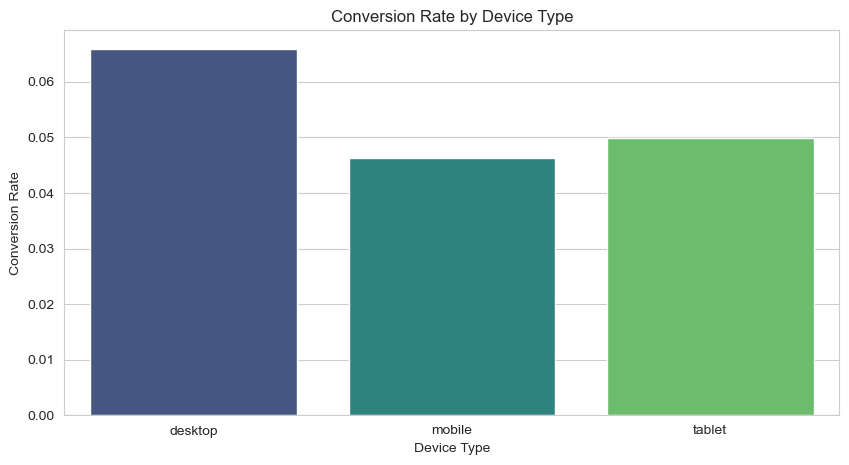

In [16]:
# Group by device type
device_analysis = df.groupby('device_type').agg(
    session_count=('session_id', 'count'),
    avg_session_length=('session_length_minutes', 'mean'),
    avg_pages_visited=('pages_visited', 'mean'),
    conversion_rate=('conversion', 'mean')
).reset_index()

print("--- Analysis by Device Type ---")
print(device_analysis)

# Plotting Conversion Rate by Device Type (Corrected line)
plt.figure(figsize=(10, 5))
# Assign 'device_type' to 'hue' and disable the legend
sns.barplot(data=device_analysis, x='device_type', y='conversion_rate', 
            hue='device_type', palette='viridis', legend=False) # Updated line
plt.title('Conversion Rate by Device Type')
plt.ylabel('Conversion Rate')
plt.xlabel('Device Type')
plt.show()

## What are the main drivers of conversion?

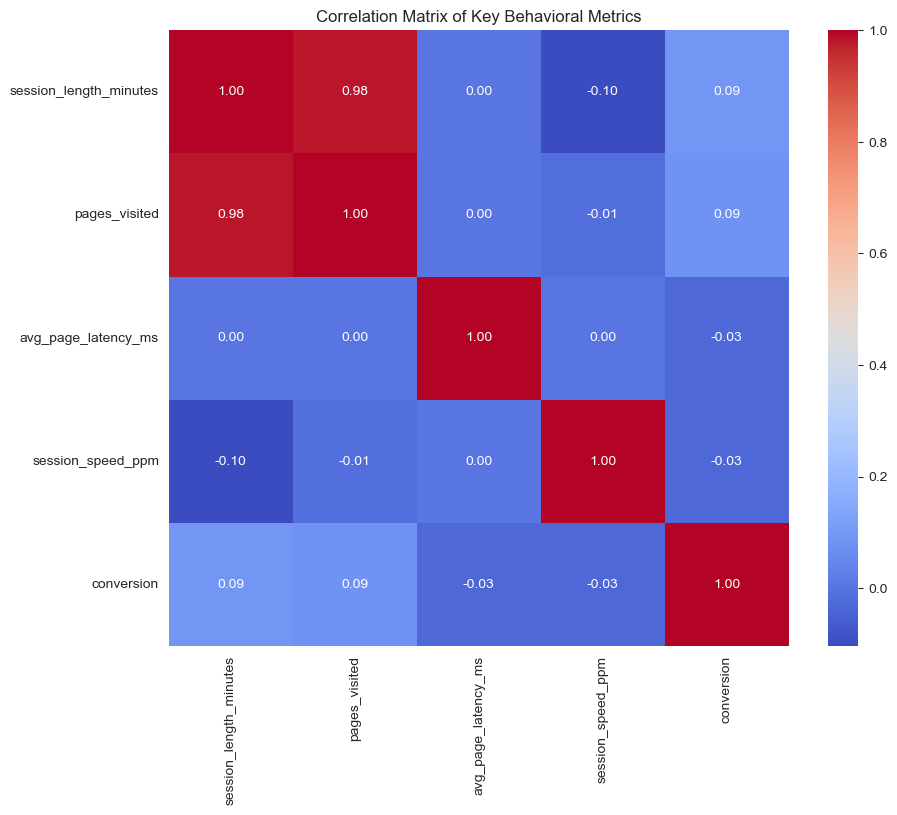

In [18]:
# Select numerical columns for correlation analysis
numerical_cols = ['session_length_minutes', 'pages_visited', 'avg_page_latency_ms', 'session_speed_ppm', 'conversion']
corr_matrix = df[numerical_cols].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Behavioral Metrics')
plt.show()

## Which segments are most likely to bounce?


--- Bounce Rate by Device ---
device_type
tablet     0.650208
mobile     0.649826
desktop    0.646375
Name: bounce, dtype: float64


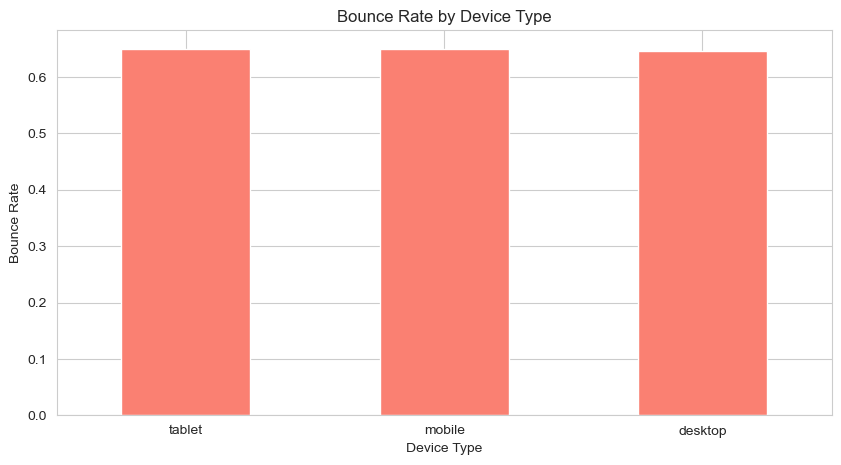

In [20]:
# Calculate bounce rate by device type
bounce_by_device = df.groupby('device_type')['bounce'].mean().sort_values(ascending=False)

print("\n--- Bounce Rate by Device ---")
print(bounce_by_device)

# Plotting Bounce Rate by Device Type
plt.figure(figsize=(10, 5))
bounce_by_device.plot(kind='bar', color='salmon')
plt.title('Bounce Rate by Device Type')
plt.ylabel('Bounce Rate')
plt.xlabel('Device Type')
plt.xticks(rotation=0)
plt.show()

In [25]:
# dashboard/app.py

import streamlit as st
import pandas as pd
import plotly.express as px

# --- Page Configuration ---
st.set_page_config(
    page_title="Web User Behaviour Analytics",
    page_icon="📊",
    layout="wide"
)

# --- Data Loading ---
@st.cache_data # Cache the data to improve performance
def load_data(path):
    """Loads the processed data from a CSV file."""
    df = pd.read_csv(path)
    df['local_time'] = pd.to_datetime(df['local_time'])
    # Ensure categorical types are set for filtering and plotting
    df['time_of_day_bin'] = pd.Categorical(df['time_of_day_bin'], categories=['Morning', 'Afternoon', 'Evening', 'Night'], ordered=True)
    return df

df = load_data('data/processed_user_data.csv')

# --- Dashboard Title ---
st.title("Web User Behaviour Analytics Dashboard")

# --- Sidebar Filters ---
st.sidebar.header("Filter Data")
selected_regions = st.sidebar.multiselect(
    "Geographic Region",
    options=df['geo_region'].unique(),
    default=df['geo_region'].unique()
)
selected_devices = st.sidebar.multiselect(
    "Device Type",
    options=df['device_type'].unique(),
    default=df['device_type'].unique()
)

# Filter the dataframe based on selection
df_filtered = df[df['geo_region'].isin(selected_regions) & df['device_type'].isin(selected_devices)]

if df_filtered.empty:
    st.warning("No data available for the selected filters.")
    st.stop()

# --- Key Metrics ---
st.header("Overall Performance")
total_sessions = df_filtered.shape[0]
total_conversions = df_filtered['conversion'].sum()
overall_conversion_rate = total_conversions / total_sessions if total_sessions > 0 else 0
avg_session_length = df_filtered['session_length_minutes'].mean()

col1, col2, col3, col4 = st.columns(4)
col1.metric("Total Sessions", f"{total_sessions:,}")
col2.metric("Total Conversions", f"{total_conversions:,}")
col3.metric("Conversion Rate", f"{overall_conversion_rate:.2%}")
col4.metric("Avg. Session Length (Min)", f"{avg_session_length:.2f}")

# --- Dashboard Tabs ---
tab1, tab2, tab3 = st.tabs(["User & Session Overview", "Engagement Analysis", "Conversion Analysis"])

with tab1:
    st.header("User & Session Overview")
    col1, col2 = st.columns(2)
    
    with col1:
        # Device Mix
        device_dist = df_filtered['device_type'].value_counts().reset_index()
        fig_device = px.pie(device_dist, names='device_type', values='count', title="Device Type Distribution")
        st.plotly_chart(fig_device, use_container_width=True)

    with col2:
        # Sessions by Region
        region_dist = df_filtered['geo_region'].value_counts().reset_index()
        fig_region = px.bar(region_dist, x='geo_region', y='count', title="Sessions by Geographic Region")
        st.plotly_chart(fig_region, use_container_width=True)

with tab2:
    st.header("Engagement Analysis")
    
    # Time of Day Analysis
    time_analysis = df_filtered['time_of_day_bin'].value_counts().sort_index().reset_index()
    fig_time = px.bar(time_analysis, x='time_of_day_bin', y='count', title="Session Volume by Time of Day")
    st.plotly_chart(fig_time, use_container_width=True)
    
    # Session Length vs. Pages Visited
    fig_scatter = px.scatter(
        df_filtered.sample(n=min(1000, len(df_filtered))), # Sample to avoid overplotting
        x='session_length_minutes', 
        y='pages_visited', 
        color='conversion',
        title="Session Length vs. Pages Visited",
        labels={'conversion': 'Converted'}
    )
    st.plotly_chart(fig_scatter, use_container_width=True)

with tab3:
    st.header("Conversion Analysis")
    col1, col2 = st.columns(2)

    with col1:
        # Conversion Rate by Device
        conv_by_device = df_filtered.groupby('device_type')['conversion'].mean().reset_index()
        fig_conv_device = px.bar(conv_by_device, x='device_type', y='conversion', title="Conversion Rate by Device Type")
        st.plotly_chart(fig_conv_device, use_container_width=True)

    with col2:
        # Conversion Rate by Campaign Source
        conv_by_campaign = df_filtered.groupby('campaign_source')['conversion'].mean().sort_values(ascending=False).reset_index()
        fig_conv_campaign = px.bar(conv_by_campaign, x='campaign_source', y='conversion', title="Conversion Rate by Campaign Source")
        st.plotly_chart(fig_conv_campaign, use_container_width=True)

2025-06-12 11:04:19.606 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 11:04:19.607 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-06-12 11:04:19.608 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 11:04:19.761 
  command:

    streamlit run /opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-06-12 11:04:19.763 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 11:04:19.763 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-12 11:04:19.764 No runtime found, using MemoryCacheStorageManager
2025-06-12 11:04:20.098 Thread 'Mai